# Given a potential suite of simulations, generate paramter.json files and figure out emulator space covered

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import copy
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import sim_params_cosmo
import sim_params_space
import write_config
import latin_hypercube
import corner
import p1d_arxiv

### Plot initial Latin hypercube

In [2]:
# get list of simulation parameters
add_slope=True
add_running=False
add_heat_amp=False
add_heat_slo=False
add_z_rei=False
param_space=sim_params_space.SimulationParameterSpace(add_slope=add_slope,add_running=add_running,
                                                        add_heat_amp=add_heat_amp,add_heat_slo=add_heat_slo,
                                                        add_z_rei=add_z_rei)
params=param_space.params
for key,param in params.items():
    print(key,param)

Om_star {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}
Delta2_star {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}
n_star {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}


In [3]:
Npar=len(params)
param_limits=np.empty([Npar,2])
for key,param in params.items():
    ip=param['ip']
    param_limits[ip][0]=param['min_val']
    param_limits[ip][1]=param['max_val']

In [4]:
# generate Latin hypercube 
nsamples=4
seed=123
cube=latin_hypercube.get_hypercube_samples(param_limits, nsamples, prior_points = None, seed=seed)

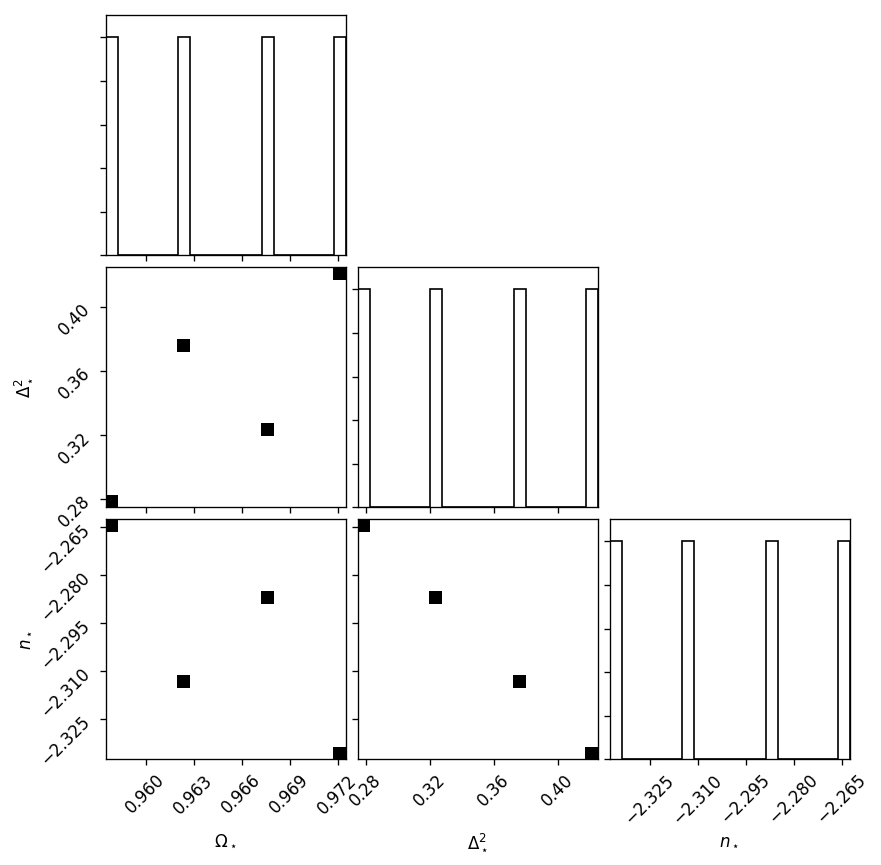

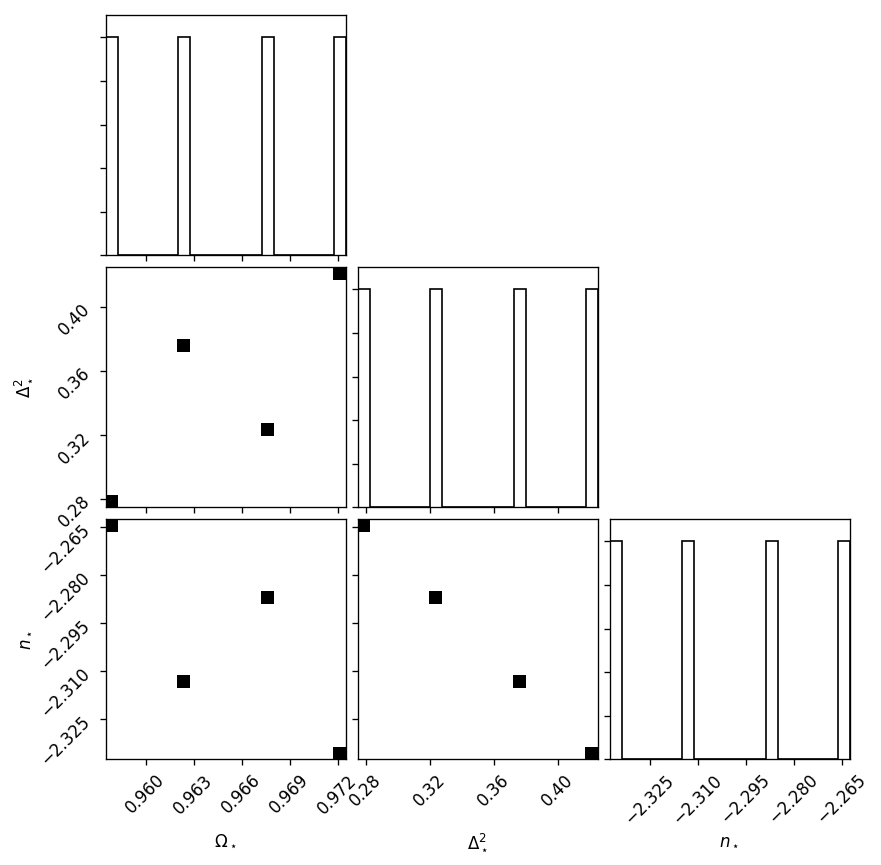

In [5]:
labels=['']*Npar
for key,param in params.items():
    ip=param['ip']
    labels[ip]=param['latex']
corner.corner(cube,labels=labels)

###  Plot cosmological parameters in initial setup

 - For each point in cube, write configuration files to run simulation

In [6]:
zs=[5.0,4.0,3.0,2.0]
sims_dir='test_dry_run/'
os.makedirs(sims_dir,exist_ok=True)
write_config.write_cube_json_file(sims_dir,params,cube)
info_cosmologies=[]
for sample in range(nsamples):
    sim_params=cube[sample]
    print(sample,sim_params)
    cosmo_sim=sim_params_cosmo.cosmo_from_sim_params_new(param_space,sim_params,verbose=False)
    sim_dir=sims_dir+'/sim_pair_'+str(sample)+'/'
    os.makedirs(sim_dir,exist_ok=True)
    # construct linear power model and store in JSON format
    linP_zs=write_config.write_sim_json_file_new(sim_dir,param_space,cosmo_sim,zs=zs)
    # store information for plots
    info_cosmo={'cosmo':cosmo_sim,'sim_params':sim_params,'linP_zs':linP_zs}
    info_cosmologies.append(info_cosmo)

0 [ 0.9625  0.375  -2.3125]
1 [ 0.9675  0.325  -2.2875]
2 [ 0.9725  0.425  -2.3375]
3 [ 0.9575  0.275  -2.2625]


In [7]:
print('sim_params',info_cosmologies[0]['sim_params'])

sim_params [ 0.9625  0.375  -2.3125]


['$H_0$', '$\\Omega_m$', '$A_s$', '$n_s$']


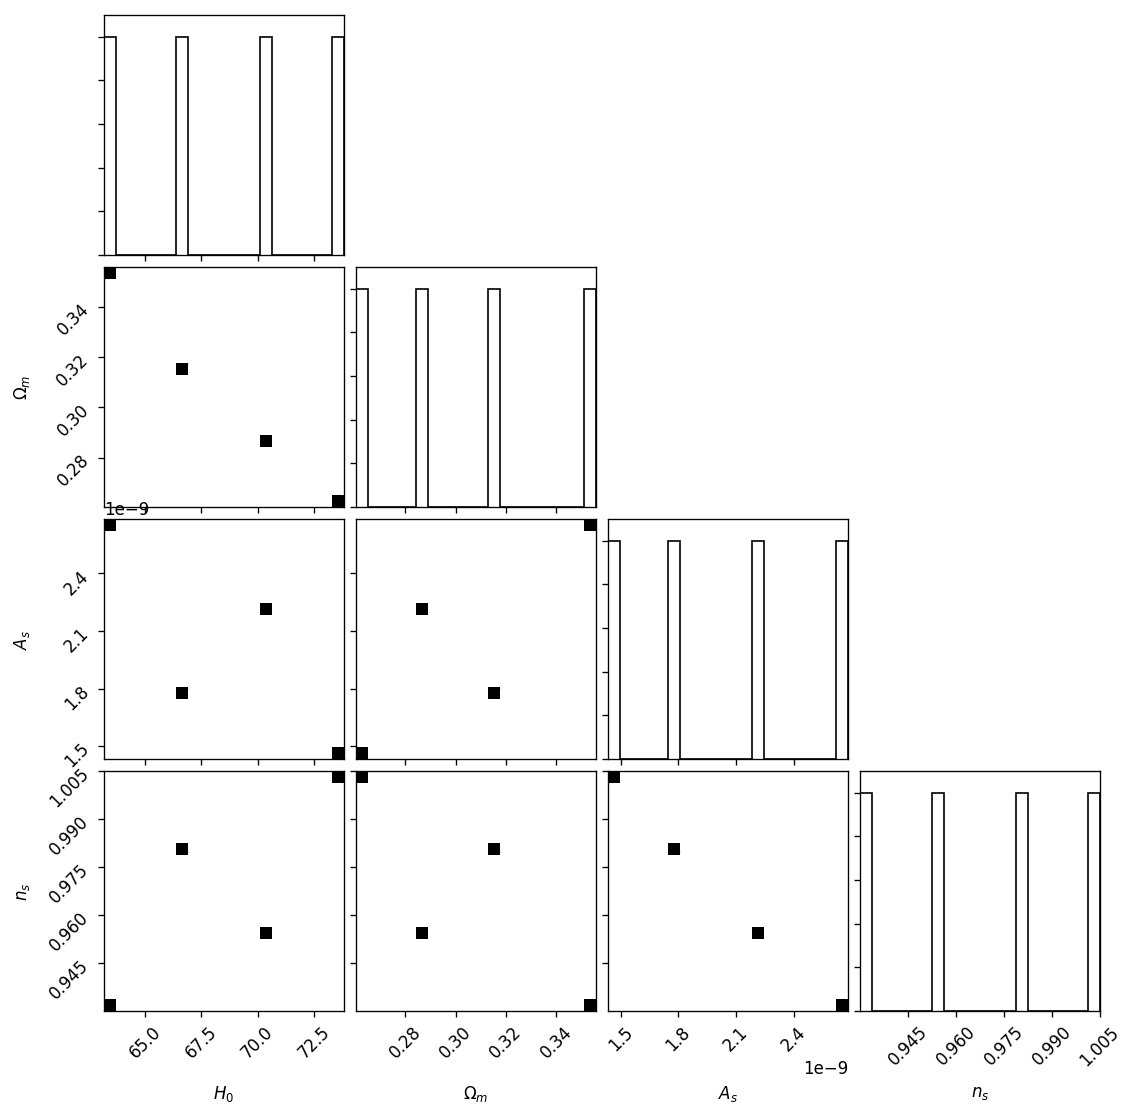

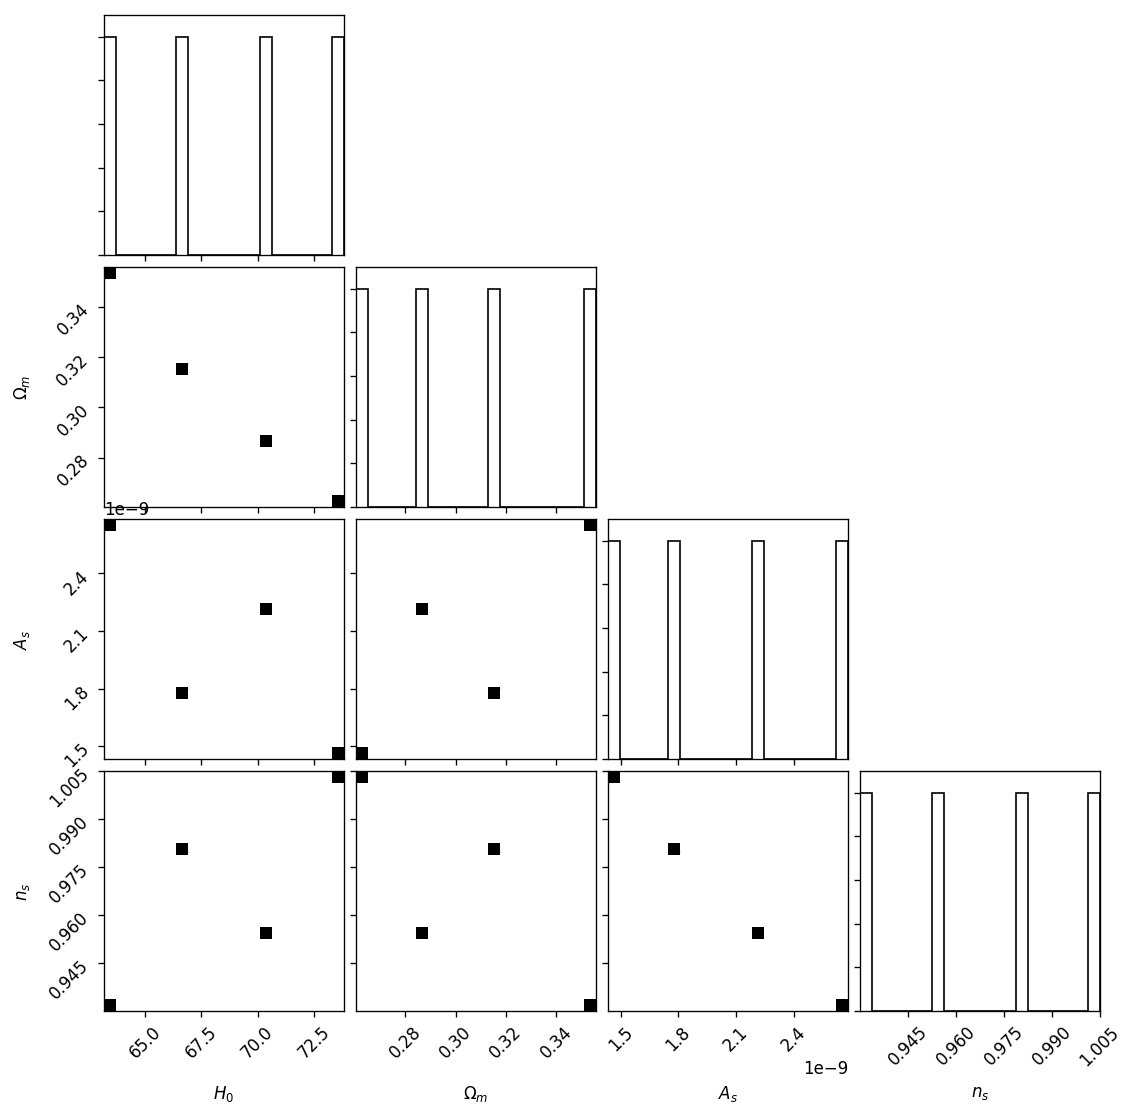

In [8]:
# plot corner plot for derived parameters
derived_labels=[r'$H_0$',r'$\Omega_m$',r'$A_s$']
if add_slope:
    derived_labels.append(r'$n_s$')
if add_running:
    derived_labels.append(r'$\alpha_s$')
Npar=len(derived_labels)
Ncos=len(info_cosmologies)
print(derived_labels)
derived_params=np.ndarray([Ncos,Npar])
for icosmo in range(Ncos):
    cosmo = info_cosmologies[icosmo]['cosmo']
    H0=cosmo.H0
    h=H0/100.0
    omh2=cosmo.omch2+cosmo.ombh2
    derived_params[icosmo][0]=H0
    derived_params[icosmo][1]=(omh2/h**2)
    derived_params[icosmo][2]=cosmo.InitPower.As
    if add_slope:
        derived_params[icosmo][3]=cosmo.InitPower.ns
    if add_running:
        derived_params[icosmo][4]=cosmo.InitPower.nrun
corner.corner(derived_params,labels=derived_labels)

In [9]:
arxiv=p1d_arxiv.ArxivP1D(basedir='setup_simulations/notebooks/'+sims_dir,skewers_label=None,
                         no_skewers=True,verbose=True)
Nmodels=len(arxiv.data)
print('# models =',Nmodels)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}}, 'nsamples': 4, 'samples': {'0': [0.9624999999999999, 0.375, -2.3125], '1': [0.9675, 0.325, -2.2875], '2': [0.9724999999999999, 0.42500000000000004, -2.3375], '3': [0.9575, 0.275, -2.2625]}}
simulation suite has 4 samples
0 sample has sim params = [0.9624999999999999, 0.375, -2.3125]
simulation has 4 redshifts
undersample_z = 1
Use linP_zs from parameter.json
1 sample has sim params = [0.9675, 0.325, -2.2875]
simulation has 4 redshifts
undersample_z = 1
Use linP_zs from parameter.json
2 sample has sim params = [0.9724999999999999, 0.42500000000000004, -2.3375]
simulation has 4 redshifts
undersample_z = 1
Use linP_zs from

In [10]:
labels=[r'$\Delta_p^2$',r'$n_p$',r'$\alpha_p$',r'$f_p$']
Npar=len(labels)
database=np.empty([Nmodels,Npar])
database[:,0]=arxiv.Delta2_p
database[:,1]=arxiv.n_p
database[:,2]=arxiv.alpha_p
database[:,3]=arxiv.f_p

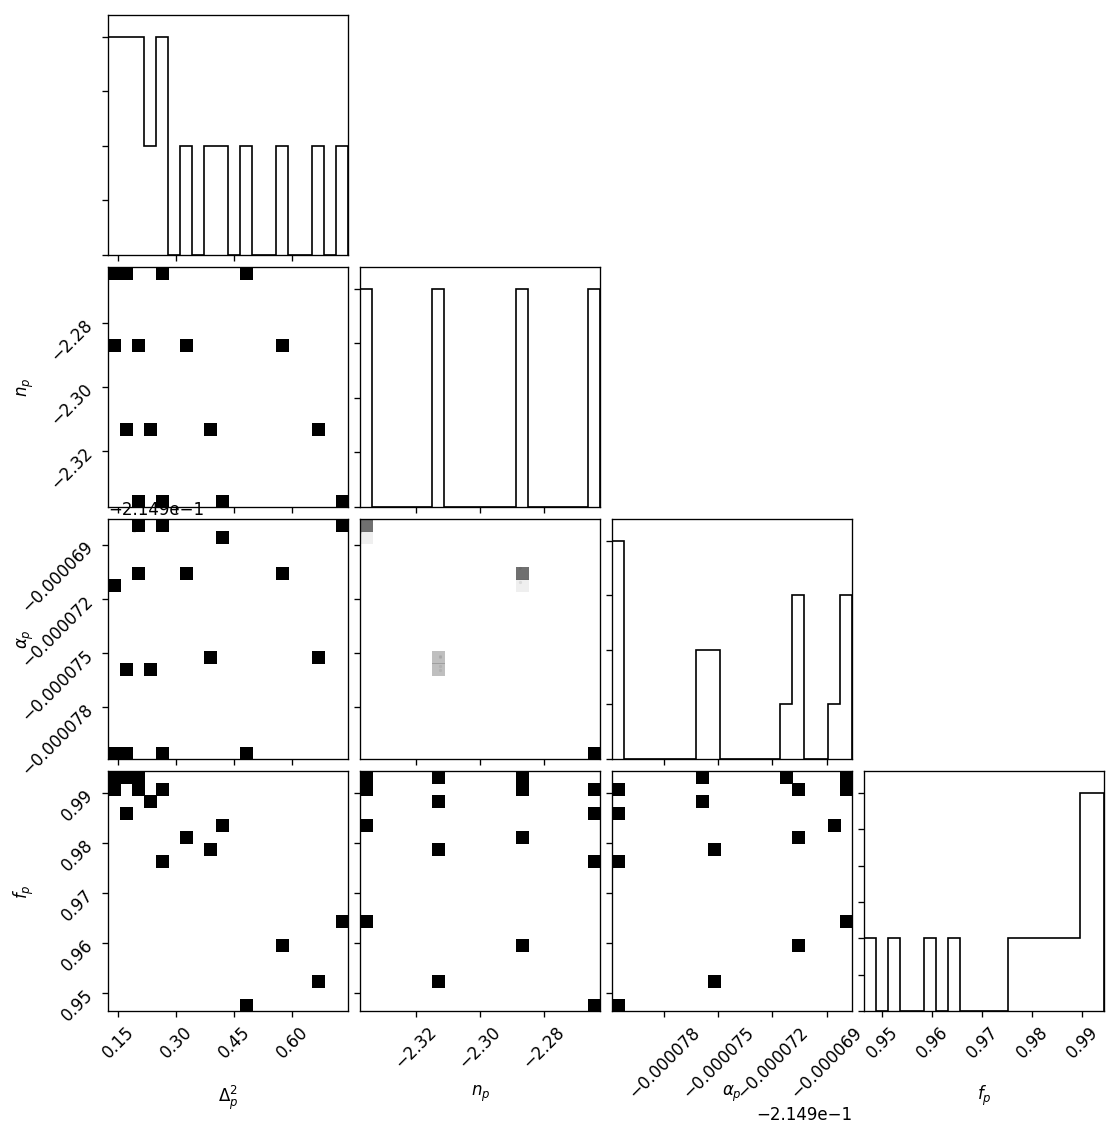

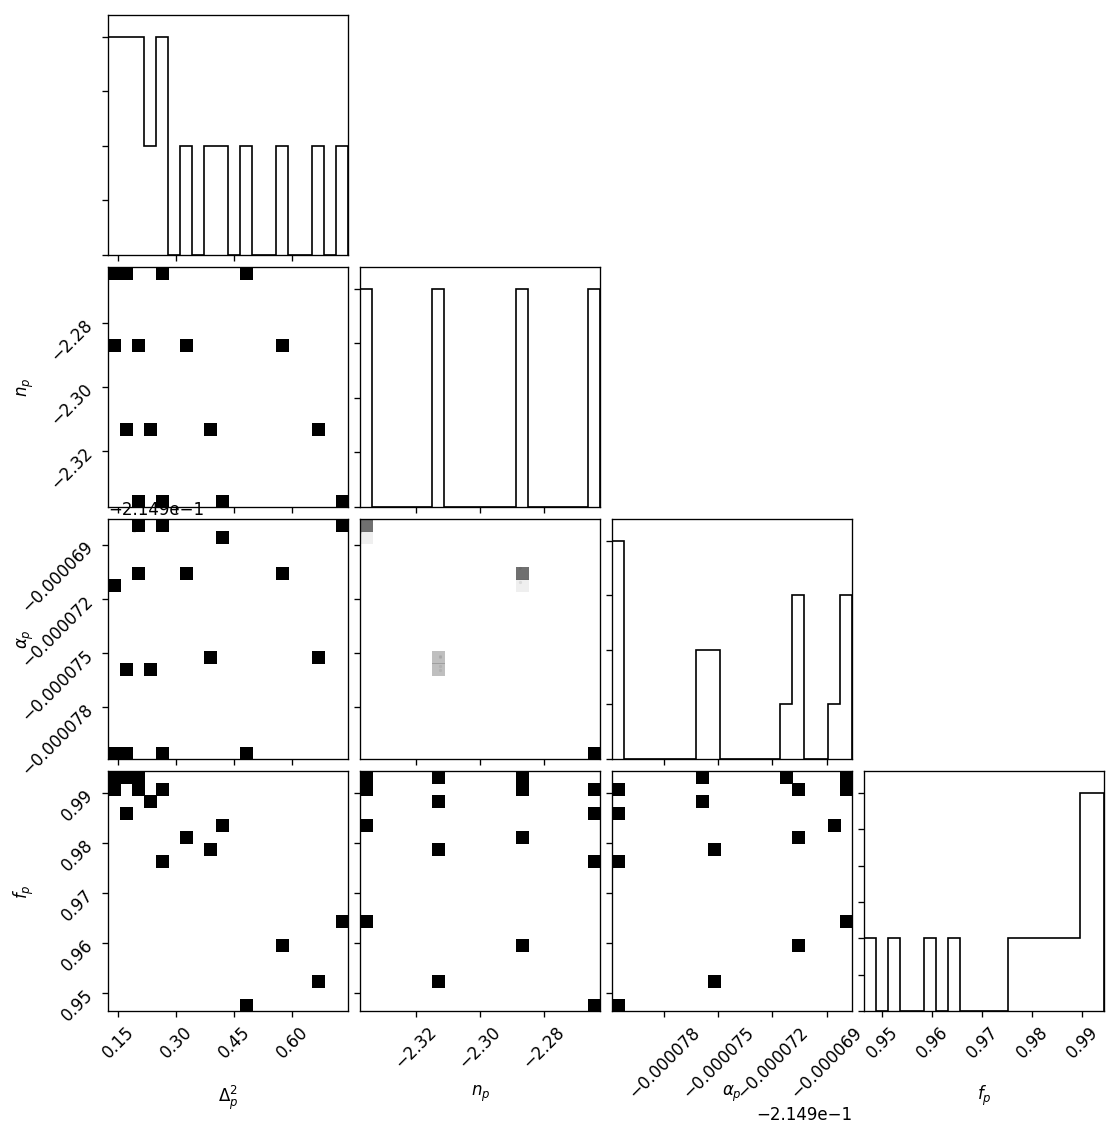

In [11]:
corner.corner(database, labels=labels,plot_contours=False)

In [12]:
def plot_parameter_pair(arxiv,param_1,param_2,plot_z=True):
    # figure out values of param_1,param_2 in arxiv
    val_1=np.array([arxiv.data[i][param_1] for i in range(len(arxiv.data))])
    print(param_1,'first values in arxiv',val_1[:5])
    val_2=np.array([arxiv.data[i][param_2] for i in range(len(arxiv.data))])
    print(param_2,'first values in arxiv',val_2[:5])
    if plot_z:
        z=np.array([arxiv.data[i]['z'] for i in range(len(arxiv.data))])
        zmin=min(z)
        zmax=max(z)
        plt.scatter(val_1,val_2,c=z,s=5,vmin=zmin, vmax=zmax)
        cbar=plt.colorbar()
        cbar.set_label("Redshift", labelpad=+1)
    else:
        plt.scatter(val_1,val_2,s=5)
    plt.xlabel(param_1)
    plt.ylabel(param_2)

Delta2_p first values in arxiv [0.16843785 0.24172298 0.375      0.65420328 0.1457864 ]
f_p first values in arxiv [0.99269317 0.98841246 0.97868838 0.95244359 0.99354559]


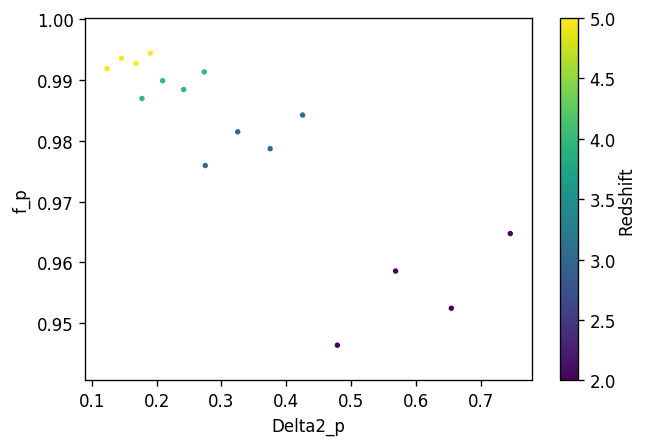

In [13]:
plot_parameter_pair(arxiv,'Delta2_p','f_p')

n_p first values in arxiv [-2.31250042 -2.31250016 -2.3125     -2.31249979 -2.28750051]
alpha_p first values in arxiv [-0.21497593 -0.2149757  -0.2149752  -0.21497524 -0.2149711 ]


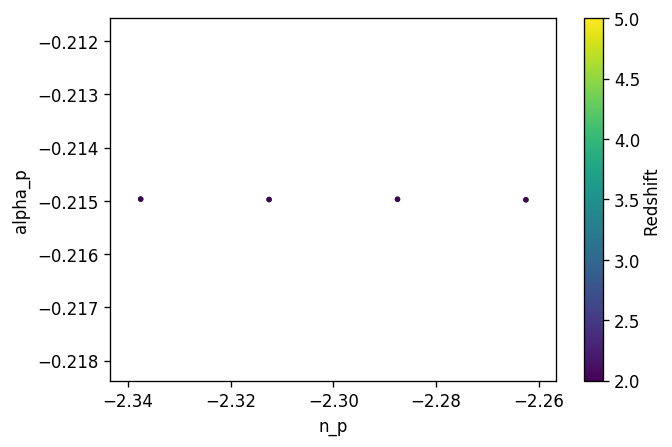

In [14]:
plot_parameter_pair(arxiv,'n_p','alpha_p')